In [1]:
import logging
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from pmdarima import auto_arima
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [2]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [3]:
df_raw.sample(10,random_state=2025)

,date,sales
129,2023-01-10 17:10:08.079328,386.975810
86,2022-11-28 17:10:08.079328,277.371955
286,2023-06-16 17:10:08.079328,791.247802
223,2023-04-14 17:10:08.079328,631.855403
56,2022-10-29 17:10:08.079328,195.952976
128,2023-01-09 17:10:08.079328,385.167569
33,2022-10-06 17:10:08.079328,129.948022
58,2022-10-31 17:10:08.079328,199.055938
32,2022-10-05 17:10:08.079328,130.624314
7,2022-09-10 17:10:08.079328,67.765106


In [4]:
df_baking = df_raw.copy()
df_baking["date"] = pd.to_datetime(df_baking["date"])
df_baking["date"] = df_baking["date"].dt.date
df_baking = df_baking.set_index("date")
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 2022-09-03 to 2023-09-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB


In [5]:
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]
df_train

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633
...,...
2023-08-18,959.405128
2023-08-19,958.666472
2023-08-20,959.248269


In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,354.0,509.35677,266.069037,53.803211,278.788227,508.070259,738.809984,970.257979


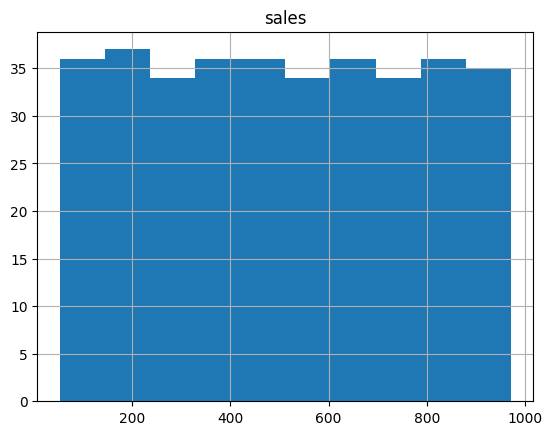

In [7]:
df_train.hist()
plt.show()

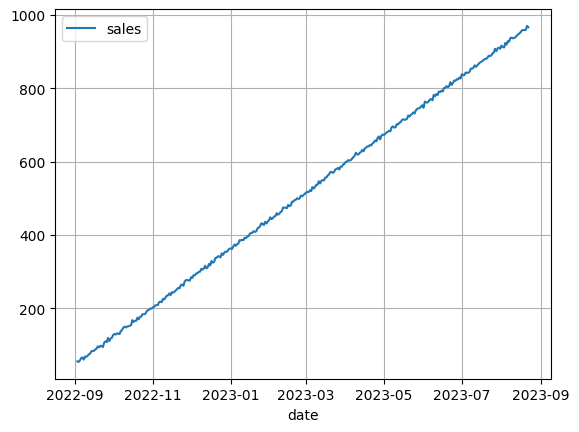

In [8]:
sns.lineplot(df_train)
plt.grid(True)
plt.show()

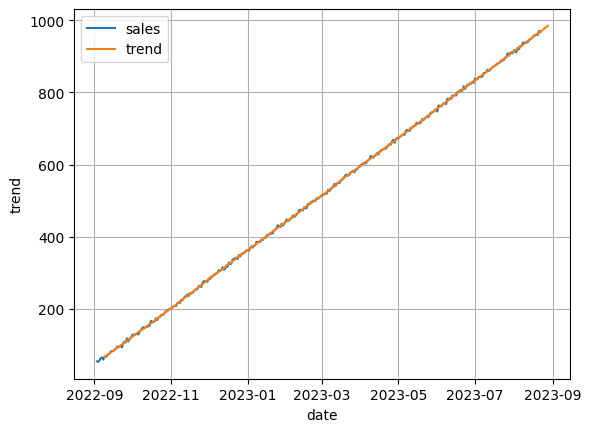

In [9]:
decomposition = seasonal_decompose(df['sales'],period=12)
trend = decomposition.trend
sns.lineplot(df_train)
sns.lineplot(trend,label='trend')
plt.grid(True)
plt.show()

Se observa una clara tendencia positiva a lo largo de los meses.

## Análisis de estacionalidad

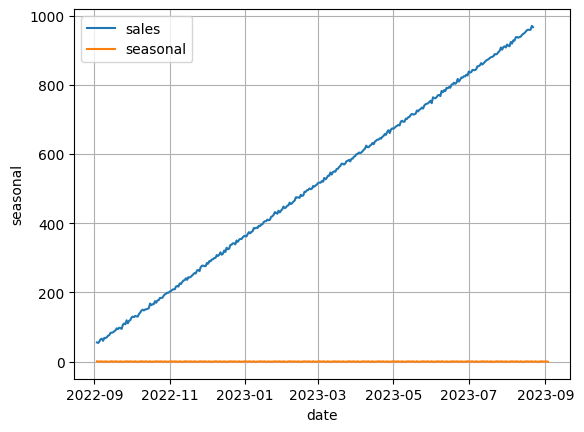

In [10]:
seasonal = decomposition.seasonal
sns.lineplot(df_train)
sns.lineplot(seasonal,label='seasonal')
plt.grid(True)
plt.show()

Para evaluar la estacionalidad, tambien podemos aplicar la preuba de Dickey-Fuller

In [11]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df_train)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.332016
p-value                          0.978767
#Lags Used                      13.000000
Number of Observations Used    340.000000
Critical Value (1%)             -3.449730
Critical Value (5%)             -2.870079
Critical Value (10%)            -2.571319
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que esta serie como no estacionaria.


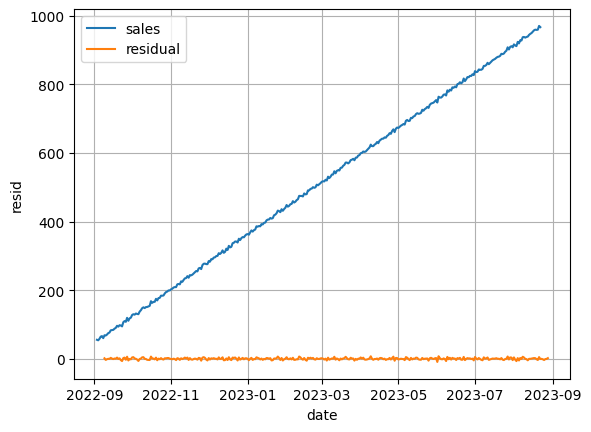

In [12]:
decomposition = seasonal_decompose(df['sales'],period=12)
residual = decomposition.resid
sns.lineplot(df_train)
sns.lineplot(residual,label='residual')
plt.grid(True)
plt.show()

In [13]:
# alpha = 0.05 if the p value is above alpha then we can say that it is not stationary (it has trend)
# if p value < alpha then we can rule out that it is stationary  (it has no trend)
ad_fuller = adfuller(df_train)
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: 0.33
adf P Value: 0.98


In [14]:
ad_fuller = adfuller(df_train['sales'].diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -9.22
adf P Value: 0.00


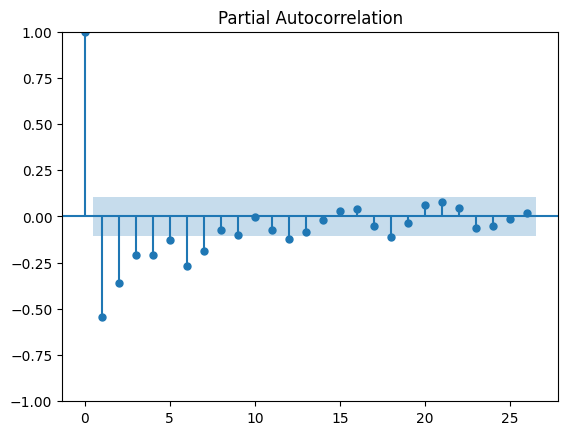

In [15]:
# value p is the autoregressive term - autoregressive = seasonality
plot_pacf(df_train.diff().dropna())
plt.show()

In [16]:
arima = ARIMA(df['sales'],order=(1,1,1)) # order variables above 'd' (differencing),'p' (partial autocorrelation), 'q' (moving average) the goal in setting these is to make the P>|z| to be the lowest possible. find the lowest AIC or P>|z| for highest precision
ts_arima = arima.fit()
print(ts_arima.summary())

/workspaces/machine-learning-python-template/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/machine-learning-python-template/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/machine-learning-python-template/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1049.226
Date:                Wed, 26 Mar 2025   AIC                           2104.453
Time:                        21:44:05   BIC                           2116.152
Sample:                    09-03-2022   HQIC                          2109.102
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   2025.703      0.000       0.999       1.001
ma.L1         -0.9996      0.440     -2.271      0.023      -1.862      -0.137
sigma2        18.1480      8.139      2.230      0.0

Hice una corrida del modelo, con la funcion pmdarima, y arrojo que este es el mejor modelo y mejor on un AIC a

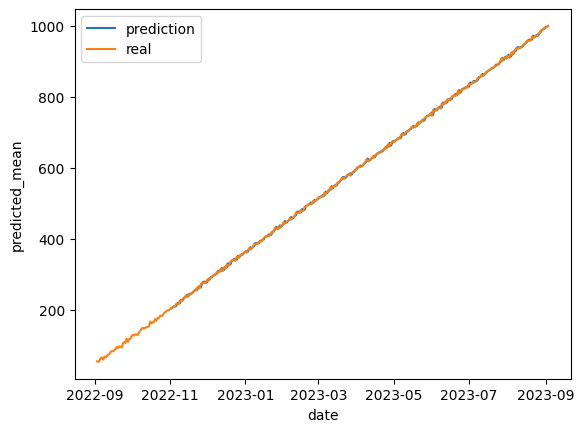

In [17]:
y_hat = ts_arima.predict(60) # argument 1, how many points into the future do you want to predict?
sns.lineplot(y_hat, label='prediction')
sns.lineplot(df['sales'],label='real')
plt.show()